# ${\rm SU}(N_c) \times {\rm SU}(N_c)$ Principal Chiral Model investigation

**Formulation**

In the continuum, the ${\rm SU}(N_c) \times {\rm SU}(N_c)$ principal chiral model is defined by the Lagrangian density

$$\mathscr{L} = \frac{1}{T} {\rm Tr}\left(\partial_\mu U \partial_\mu U^\dagger\right).$$
To discretize this onto a lattice, consider the naive finite difference:
	$$\partial_\mu U(x) \rightarrow U(x + \hat{\mu}) - U(x),$$
so that the product becomes
	$$\partial_\mu U(x) \partial_\mu U^\dagger(x) 
		\rightarrow \left(U(x + \hat{\mu}) - U(x)\right) \left(U(x + \hat{\mu}) - U(x)\right)^\dagger \\
		= 2\mathbb{I} - U(x + \hat{\mu}) U^\dagger(x) - U(x) U^\dagger(x + \hat{\mu}).$$
The identity will just yield an overall normalization, so we ignore this. Tracing over this quantity then gives 
	$$-{\rm Tr}\left\{U^\dagger(x) U(x + \hat{\mu}) + \left(U^\dagger(x) U(x + \hat{\mu})\right)^\dagger\right\} = -2 {\rm Re}{\rm Tr} \left\{U^\dagger(x) U(x + \hat{\mu})\right\}.$$
Defining an inverse temperature parameter by $\beta := \frac{1}{N_c T}$, we write down the principal chiral model on the lattice as
	$$S[U] = -\beta N_c \sum_x \sum_\mu {\rm Re}{\rm Tr}\left\{U^\dagger(x) U(x + \hat{\mu})\right\}$$
This is notationally equivalent to the form that Horsley et al. [[arXiv:2503.20898](https://arxiv.org/abs/2503.20898)] write down in Eq.(3).

**Symmetries**

In the ${\rm SU}(N_c) \times {\rm SU}(N_c)$ PCM, group degrees of freedom transform under the bi-fundamental representation. Two important symmetries that this model exhibits:
- Invariance under charge / parity conjugation: $U(x) \mapsto U^\dagger(x)$
- Invariance under left / right multiplication: $U(x) \mapsto V_L U(x) V_R^\dagger$

## Setup

In [1]:
# General imports
import torch
import numpy as np

import matplotlib.pyplot as plt

In [2]:
# Imports from our repo
import sys
sys.path.insert(0, '../src/')

from linalg import trace, adjoint
from utils import roll, grab
from sun import proj_to_algebra, random_sun_element, random_sun_lattice
from action import SUNPrincipalChiralAction

[Testing SUNPrincipalChiralAction]
[PASSED]


## Generate configurations

In [3]:
# TODO: more efficient dS computation with alternating checkerboard mask
def apply_metropolis(batch_size, L, Nc, action, num_steps, step_size):
    """Batched Metropolis sampler."""
    action_vals = []
    accept_rates = []
    
    batch_shape = (batch_size, L, L)
    U = random_sun_lattice(batch_shape, Nc=Nc)
    for _ in range(num_steps):
        # Proposal
        V_re = torch.eye(Nc).repeat(batch_size, L, L, 1, 1) 
        V_im = step_size * torch.randn((batch_size, L, L, Nc, Nc))
        V = V_re + 1j*V_im
        V = torch.matrix_exp(1j * proj_to_algebra(V))  # random group noise
        Up = V @ U
        dS = action(Up) - action(U)

        # Accept / Reject
        r = torch.rand((batch_size,))  # accept w/ prob = exp(-dS)
        accept_mask = (r < torch.exp(-dS))[:, None, None, None, None]
        U = torch.where(accept_mask, Up, U)

        action_vals.append(grab(action(U).mean()))
        accept_rates.append(grab(torch.sum(accept_mask) / batch_size))

    return U, action_vals, accept_rates

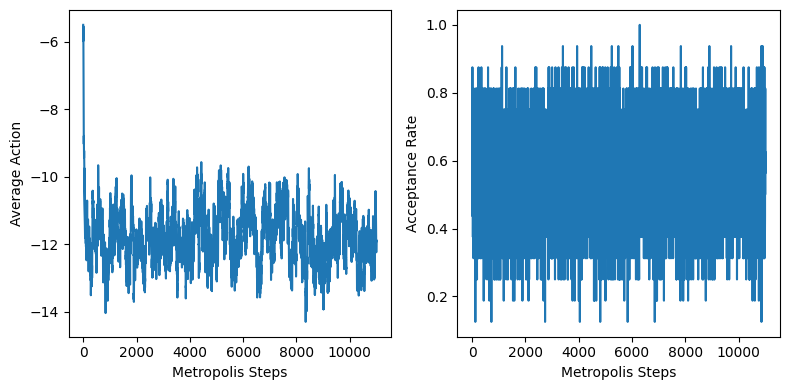

In [4]:
# Define physical theory
beta = 0.3
action = SUNPrincipalChiralAction(beta)


# Generate samples
num_train = 2 ** 4
num_therm = 1_000
num_iters = 10_000
step_size = 0.35

U_train, action_vals, accept_rates = apply_metropolis(
    batch_size = num_train,
    Nc = 2,
    L = 4,
    action = action,
    num_steps = num_therm + num_iters,
    step_size = step_size
)


# Visualize Metropolis
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for ax in axes:
    ax.set_xlabel('Metropolis Steps')

axes[0].plot(action_vals)
axes[0].set_ylabel('Average Action')

axes[1].plot(accept_rates)
axes[1].set_ylabel('Acceptance Rate')

fig.tight_layout()
fig.show();